# Anomaly Detection with Autoencoders

In [2]:
import librosa 
from scipy.io import wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa

### Extract an MFCC for each cough audio file in the dataset and store it in a Panda Dataframe along with it's class label 

In [20]:
def extract_mfccs(dir, file_name):
   
    try:
        audio, sample_rate = librosa.load(dir + file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsnorm = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("file could not be loaded: ", file_name)
        return None 
     
    return mfccsnorm

In [3]:
# Set the path to the cough dataset 
fulldatasetpath = "C:/Users/u144572/self_development/single-Class-Audio-Classification/single_cycle/"

features = []

for filename in os.listdir(fulldatasetpath):
    data = extract_mfccs(fulldatasetpath, filename)
    
    features.append([data, "respiratory_cycle"])

# Convert into a Panda dataframe 
featuresdataframe = pd.DataFrame(features, columns=['feature','class_label'])

print('features extracted from ', len(featuresdataframe), ' files') 

features extracted from  4346  files


In [4]:
print(featuresdataframe)

                                                feature        class_label
0     [-338.28937, 114.181404, 60.625134, 41.543037,...  respiratory_cycle
1     [-327.0864, 119.97717, 67.03744, 41.687347, 33...  respiratory_cycle
2     [-311.67795, 126.33622, 70.21532, 38.241367, 2...  respiratory_cycle
3     [-317.32016, 130.61546, 66.81108, 37.348442, 3...  respiratory_cycle
4     [-318.39294, 124.59955, 67.787125, 37.56144, 2...  respiratory_cycle
...                                                 ...                ...
4341  [-246.30447, 186.84789, 65.68468, 19.117262, 9...  respiratory_cycle
4342  [-248.1316, 194.57927, 65.00773, 16.558573, 8....  respiratory_cycle
4343  [-241.64798, 196.95132, 66.00626, 10.483316, 5...  respiratory_cycle
4344  [-239.80019, 192.65627, 62.95427, 14.617298, 8...  respiratory_cycle
4345  [-235.86623, 198.48456, 62.159225, 12.77641, 5...  respiratory_cycle

[4346 rows x 2 columns]


### Convert the categorical text data into model-understandable numerical data. 

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and Class labels into numpy arrays
X = np.array(featuresdataframe.feature.tolist())
y = np.array(featuresdataframe.class_label.tolist())

# Encode the classification labels
labelen = LabelEncoder()
classen = to_categorical(labelen.fit_transform(y)) 

### Split the dataset into training and testing sets. The testing set size will be 10% and we will set a random state. 


In [6]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, classen, test_size=0.1, random_state = 42)

In [7]:
print(f"train count: {len(x_train)}")

train count: 3911


In [8]:
input_dim = x_train.shape[1]
print(input_dim)

40


In [9]:
print(X.shape[1])

40


### Create the Autoencoder Model with L1 Sparsity Penalty as 1e-5 and Loss function as MSE

In [10]:
from sklearn import metrics
import numpy as np
import pandas as pd
from IPython.display import display, HTML 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.regularizers import l1

model = Sequential()
model.add(Dense(512, input_dim=X.shape[1], activity_regularizer=l1(0.00001), activation='relu'))
model.add(Dense(224, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(X.shape[1])) # Multiple output neurons

model.summary()

C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 224)            │       114,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │        20,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,624 (1.04 MB)

 Trainable params: 271,624 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [12]:
history=model.fit(x_train,x_train,verbose=1,epochs=90)

Epoch 1/90
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9209 - loss: 475.8084
Epoch 2/90
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.7614
Epoch 3/90
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.2717
Epoch 4/90
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.9723
Epoch 5/90
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.3492
Epoch 6/90
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.9669
Epoch 7/90
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.6086
Epoch 8/90
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 2.3010
Epoch 9/90
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.1607
Epoch 10/90
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9695
Epoch 11/90
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.8703
Epoch 12/90
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

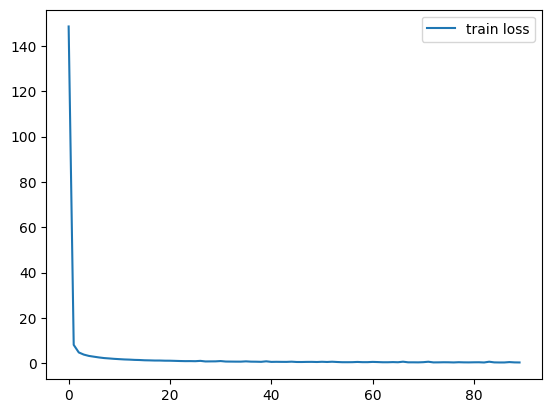

In [13]:
plt.plot(history.history['loss'], label='train loss')
#plt.plot(history.history['accuracy'], label='Accuracy')
plt.legend()
plt.show()

### Calculate the MSE for the Test Dataset (out of sample) and on the Whole Dataset (In + Out Sample)

In [14]:
pred = model.predict(x_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,x_test))
pred = model.predict(X)
score2 = np.sqrt(metrics.mean_squared_error(pred,X))

print(f"Out of Sample Score (RMSE): {score1}")
print(f"Insample Normal Score (RMSE): {score2}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Out of Sample Score (RMSE): 0.39076319336891174
Insample Normal Score (RMSE): 0.38781896233558655


### Use the model to predict the MSE for validation set 

In [21]:
prediction_feature = extract_mfccs("single_cycle/", "107_2b3_Al_mc_AKGC417L_segment_04.wav")

In [18]:
pred = model.predict(prediction_feature)
score3 = np.sqrt(metrics.mean_squared_error(pred, prediction_feature))
print(f"Validation sample (RMSE): {score3}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation sample (RMSE): 1.2506624460220337


### Save the Model

In [55]:
import os
import numpy as np
import librosa
from pydub import AudioSegment
from sklearn import metrics

def extract_mfccs(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsnorm = np.mean([mfccs.T], axis=0)
    except Exception as e:
        print(f"File could not be loaded: {file_path}, Error: {e}")
        return None
    return mfccsnorm

def count_respiratory_events(wav_file, model, segment_duration=3, overlap=0.1):
    # Load the audio file
    audio = AudioSegment.from_wav(wav_file)
    event_count = 0
    segment_duration_ms = segment_duration * 1000  # Convert to milliseconds
    step_size_ms = int((overlap * 1000))  # Step size based on overlap
    temp_wav_path = ""
    start_time = 0

    # Process the audio in overlapping segments
    while start_time < len(audio) - segment_duration_ms:
        end_time = start_time + int(segment_duration_ms)
        segment = audio[start_time:end_time]

        # Export segment as a temporary WAV file
        temp_wav_path = "temp_segment.wav"
        segment.export(temp_wav_path, format="wav")

        # Extract features using the extract_mfccs function
        prediction_feature = extract_mfccs(temp_wav_path)
        
        if prediction_feature is not None:
            # Use the model to predict whether this segment is a respiratory cycle
            pred = model.predict(prediction_feature, verbose=0)
            score3 = np.sqrt(metrics.mean_squared_error(pred, prediction_feature))

            # Count as a respiratory event if score3 < 1
            print(score3, start_time)
            if score3 < 1.3:
                event_count += 1
                start_time += int(2*1000)  # Move start time forward by segment duration if an event is detected
            else:
                start_time += step_size_ms  # Move start time forward by step size if no event is detected

    # Clean up temporary file
    if os.path.exists(temp_wav_path):
        os.remove(temp_wav_path)

    return event_count

# Example usage
if __name__ == "__main__":
    wav_file_path = "audio_and_txt_files/107_2b3_Tc_mc_AKGC417L.wav"
    
    # Load your model here
    # model = load_your_model_function()

    # Count the respiratory events in the given WAV file
    num_events = count_respiratory_events(wav_file_path, model)
    print(f"Number of respiratory events detected: {num_events}")


2.1093001 0
1.462188 100
1.4319537 200
1.4593917 300
1.4134569 400
1.3964685 500
1.4282069 600
1.4239863 700
1.3819432 800
1.4095409 900
1.4291185 1000
1.3930314 1100
1.415872 1200
1.4204212 1300
1.3793447 1400
1.3671157 1500
1.3987274 1600
1.4112715 1700
1.3973812 1800
1.4458433 1900
1.4284847 2000
1.382985 2100
1.4044701 2200
1.4180192 2300
1.3836211 2400
1.3946599 2500
1.3945343 2600
1.3673973 2700
1.2958919 2800
1.2908279 4800
1.3819066 6800
1.3679018 6900
1.3471392 7000
1.382601 7100
1.388133 7200
1.3964909 7300
1.4113157 7400
1.4218206 7500
1.4312443 7600
1.389155 7700
1.3797014 7800
1.3512503 7900
1.3043394 8000
1.3330188 8100
1.3608282 8200
1.3567108 8300
1.3350507 8400
1.3350006 8500
1.3096893 8600
1.2984339 8700
1.2997098 10700
1.3205366 12700
1.3294933 12800
1.2832458 12900
1.2368075 14900
1.1426662 16900
Number of respiratory events detected: 7


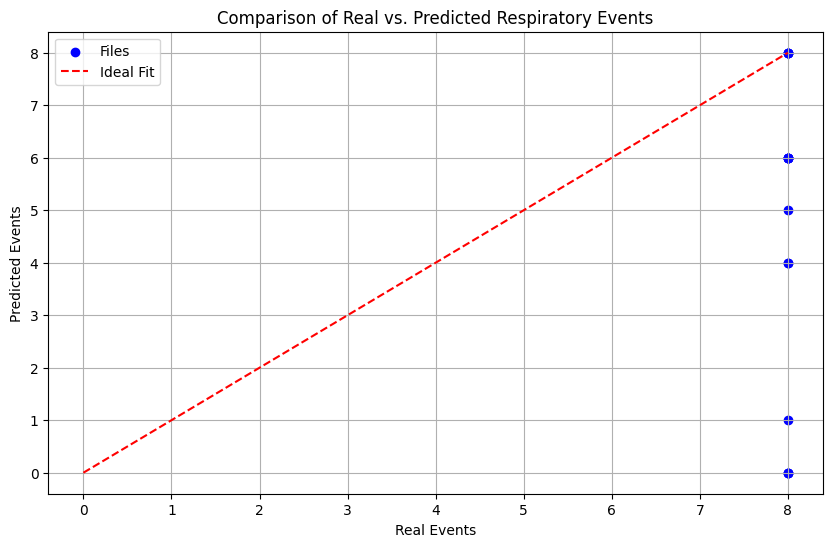

In [61]:
import os
import numpy as np
import pandas as pd
import librosa
from pydub import AudioSegment
from sklearn import metrics
import matplotlib.pyplot as plt

def extract_mfccs(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsnorm = np.mean([mfccs.T], axis=0)
    except Exception as e:
        print(f"File could not be loaded: {file_path}, Error: {e}")
        return None
    return mfccsnorm

def count_respiratory_events(wav_file, model, segment_duration=3, overlap=0.1):
    audio = AudioSegment.from_wav(wav_file)
    event_count = 0
    segment_duration_ms = segment_duration * 1000  # Convert to milliseconds
    step_size_ms = int(segment_duration_ms * (1 - overlap))  # Calculate step size
    temp_wav_path = "temp_segment.wav"
    start_time = 0

    while start_time + segment_duration_ms <= len(audio):
        end_time = start_time + segment_duration_ms
        segment = audio[start_time:end_time]
        segment.export(temp_wav_path, format="wav")
        prediction_feature = extract_mfccs(temp_wav_path)
        
        if prediction_feature is not None:
            pred = model.predict(prediction_feature, verbose=0)
            score3 = np.sqrt(metrics.mean_squared_error(pred, prediction_feature))
            if score3 < 1.3:
                event_count += 1
                start_time += int(2*1000)  # Move start time forward by segment duration if an event is detected
            else:
                start_time += step_size_ms  # Move start time forward by step size if no event is detected

    if os.path.exists(temp_wav_path):
        os.remove(temp_wav_path)

    return event_count

def count_real_events(txt_file):
    df = pd.read_csv(txt_file, sep='\t', header=None)
    return len(df)

def process_directory(directory, model):
    real_counts = []
    predicted_counts = []
    file_names = []

    for file_name in os.listdir(directory):
        if file_name.endswith('.wav'):
            base_name = os.path.splitext(file_name)[0]
            wav_file_path = os.path.join(directory, file_name)
            txt_file_path = os.path.join(directory, f"{base_name}.txt")

            if os.path.exists(txt_file_path):
                real_count = count_real_events(txt_file_path)
                predicted_count = count_respiratory_events(wav_file_path, model)
                real_counts.append(real_count)
                predicted_counts.append(predicted_count)
                file_names.append(base_name)

    return file_names, real_counts, predicted_counts

def plot_event_comparison(file_names, real_counts, predicted_counts):
    x = np.arange(len(file_names))  # The label locations
    width = 0.35  # The width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, real_counts, width, label='Real Events')
    bars2 = ax.bar(x + width/2, predicted_counts, width, label='Predicted Events')

    ax.set_xlabel('Files')
    ax.set_ylabel('Number of Events')
    ax.set_title('Comparison of Real vs. Predicted Respiratory Events')
    ax.set_xticks(x)
    ax.set_xticklabels(file_names, rotation=90)
    ax.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    directory_path = "test"

    # Load your model here
    # model = load_your_model_function()

    file_names, real_counts, predicted_counts = process_directory(directory_path, model)
    plot_event_comparison(file_names, real_counts, predicted_counts)
